# **Библиотеки**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Enable experimental features
from sklearn.experimental import enable_iterative_imputer  # Это нужно до импорта IterativeImputer

# Preprocessing
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, TargetEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# Column transformation
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV

# Models
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Metrics
from sklearn.metrics import mean_absolute_percentage_error, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, make_scorer

# Encoding (additional)
import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')

import math

# **Загрузка данных**

In [2]:
path_train = 'train.csv'  
df = pd.read_csv(path_train)
df.shape

(400, 11)

# **Исследование данных**

### **Как выглядит наши данные?**

In [3]:
display(df.head())

,wage,education,experience,age,ethnicity,region,gender,occupation,sector,union,married
0,8.50,12,16,34,cauc,other,female,technical,other,no,no
1,10.00,14,22,42,cauc,other,male,technical,other,no,yes
2,24.98,16,18,40,cauc,other,male,management,other,no,yes
3,4.50,12,3,21,cauc,other,female,management,other,no,yes
4,8.00,12,8,26,cauc,other,female,office,other,no,no


### **Какие типы данных есть в наших данных?**

In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   wage        400 non-null    float64
 1   education   400 non-null    int64  
 2   experience  400 non-null    int64  
 3   age         400 non-null    int64  
 4   ethnicity   400 non-null    object 
 5   region      400 non-null    object 
 6   gender      400 non-null    object 
 7   occupation  400 non-null    object 
 8   sector      400 non-null    object 
 9   union       400 non-null    object 
 10  married     400 non-null    object 
dtypes: float64(1), int64(3), object(7)
memory usage: 34.5+ KB


None

### **Описательная статистика**

In [5]:
display(df.describe())

,wage,education,experience,age
count,400.000000,400.000000,400.000000,400.000000
mean,9.078150,12.960000,17.860000,36.810000
std,5.274194,2.694727,12.474953,11.840159
min,1.000000,2.000000,0.000000,18.000000
25%,5.240000,12.000000,8.000000,28.000000
50%,7.670000,12.000000,15.000000,35.000000
75%,11.327500,14.250000,26.000000,44.000000
max,44.500000,18.000000,55.000000,64.000000


### **Проверка на дублирование значений**

In [6]:
display(df.nunique())

wage          189
education      17
experience     51
age            47
ethnicity       3
region          2
gender          2
occupation      6
sector          3
union           2
married         2
dtype: int64

### **Проверка на пропуски**

In [7]:
display(df.isnull().sum())

wage          0
education     0
experience    0
age           0
ethnicity     0
region        0
gender        0
occupation    0
sector        0
union         0
married       0
dtype: int64

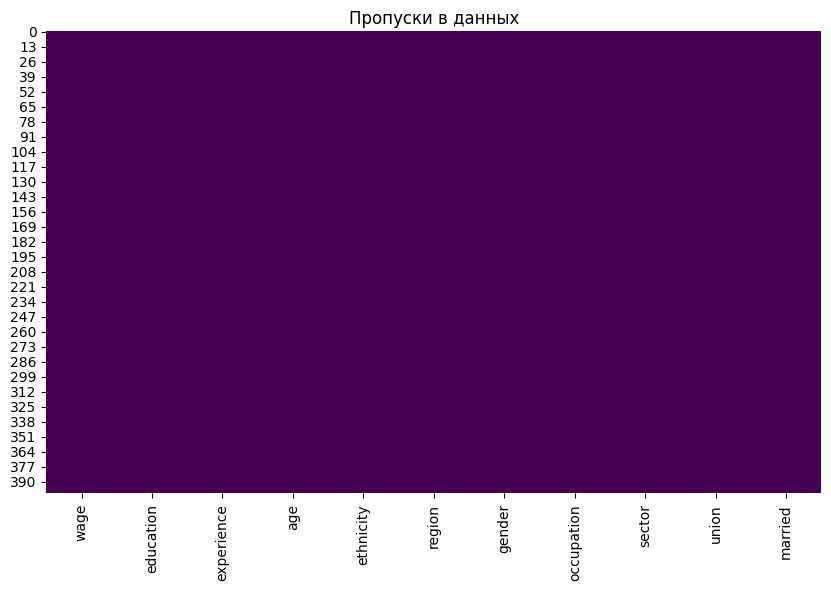

Series([], dtype: float64)


In [8]:
# Визуализация пропусков с помощью тепловой карты
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Пропуски в данных")
plt.show()

# Процент пропусков по каждому столбцу
missing_data = df.isnull().sum() / len(df) * 100
print(missing_data[missing_data > 0].sort_values(ascending=False))

### **Проверка на дубликаты**

In [9]:
display(df[df.duplicated()])

,wage,education,experience,age,ethnicity,region,gender,occupation,sector,union,married


### **Общее количество дублирующихся строк во всем DataFrame**

In [10]:
total_duplicates = df.duplicated().sum()
print(f"Общее количество дублирующихся строк во всем DataFrame: {total_duplicates}")

Общее количество дублирующихся строк во всем DataFrame: 0


### **Убираем дубликаты**

In [11]:
df = df[~df.duplicated()] # 

# **Одномерный анализ данных**

### Прикиним распределение данных в столбцах 

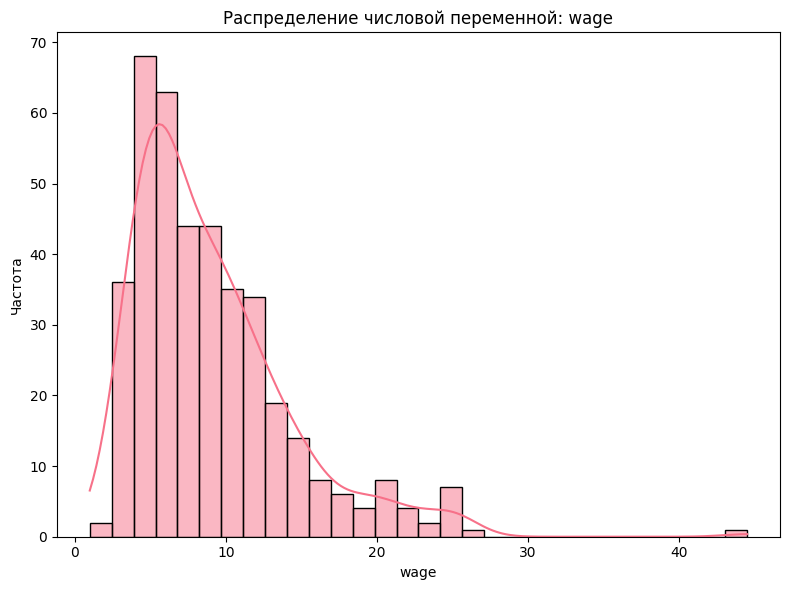

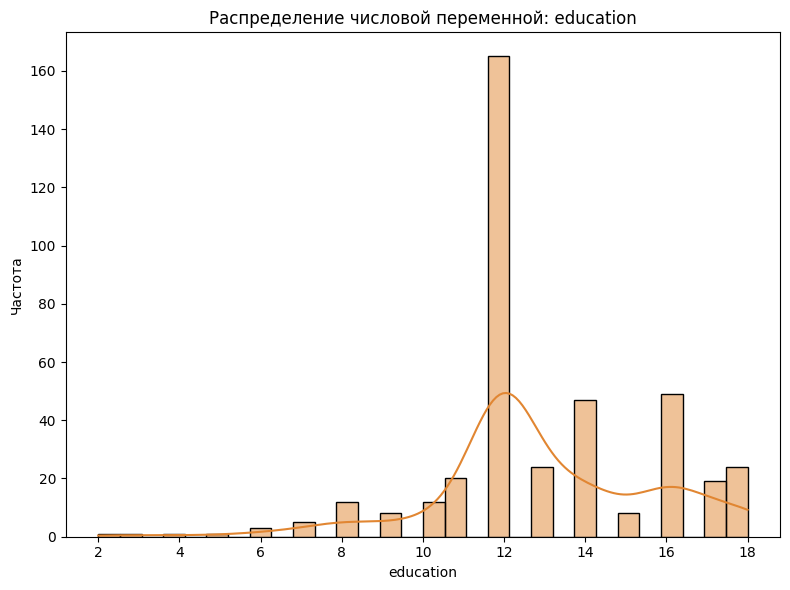

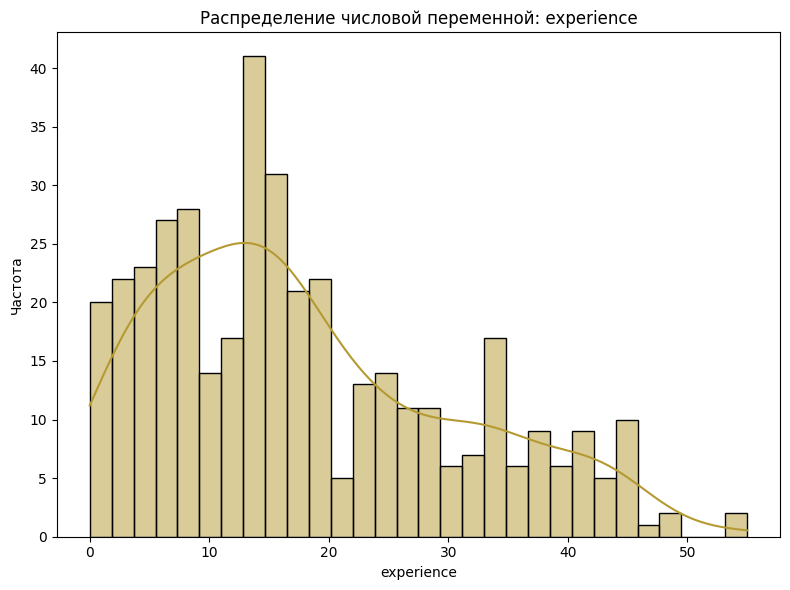

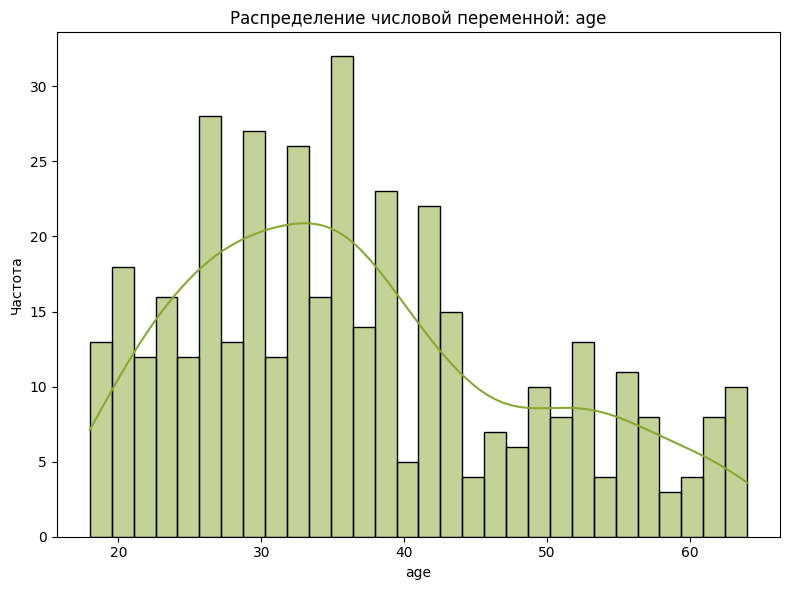

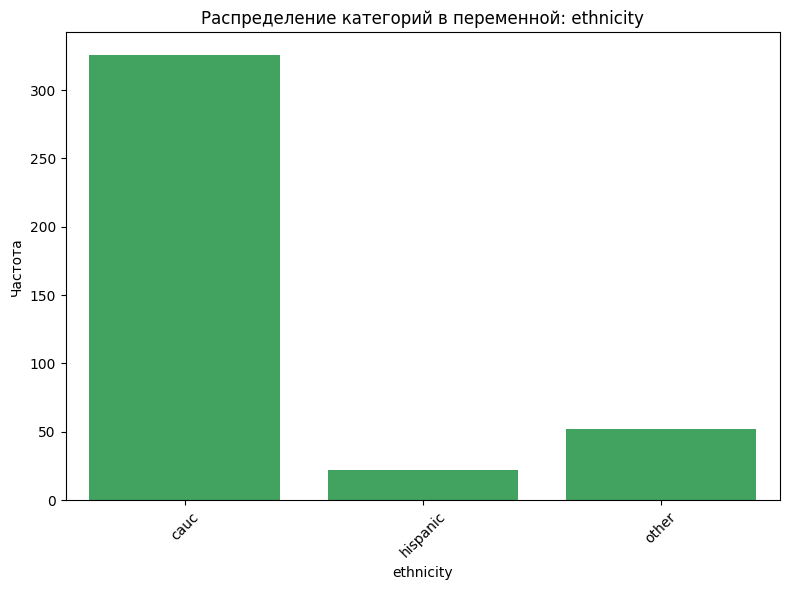

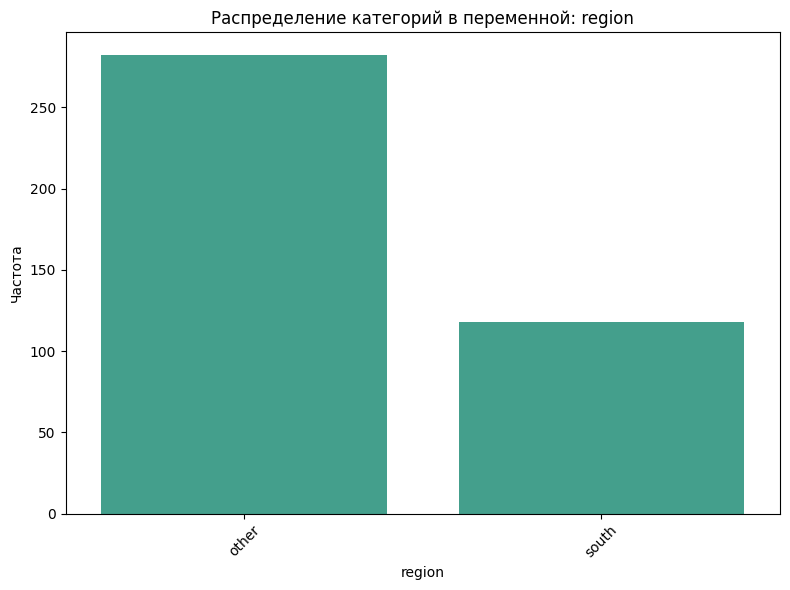

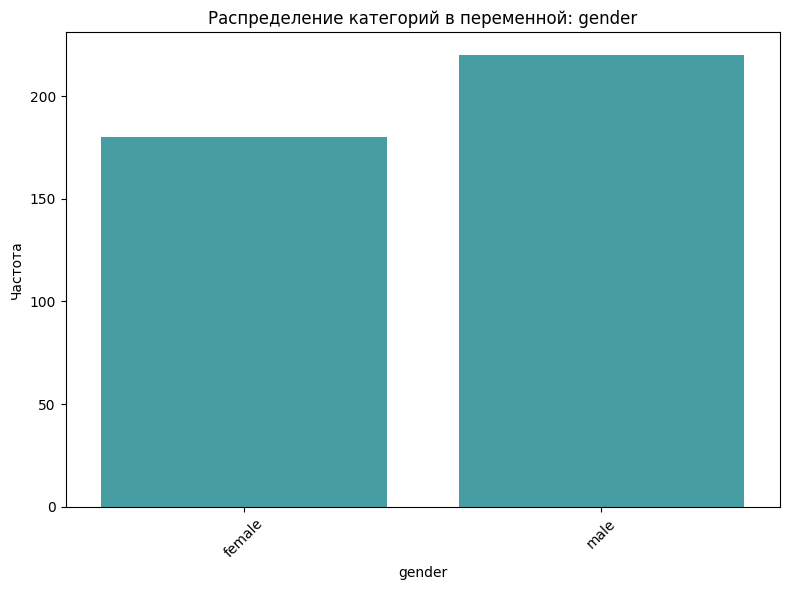

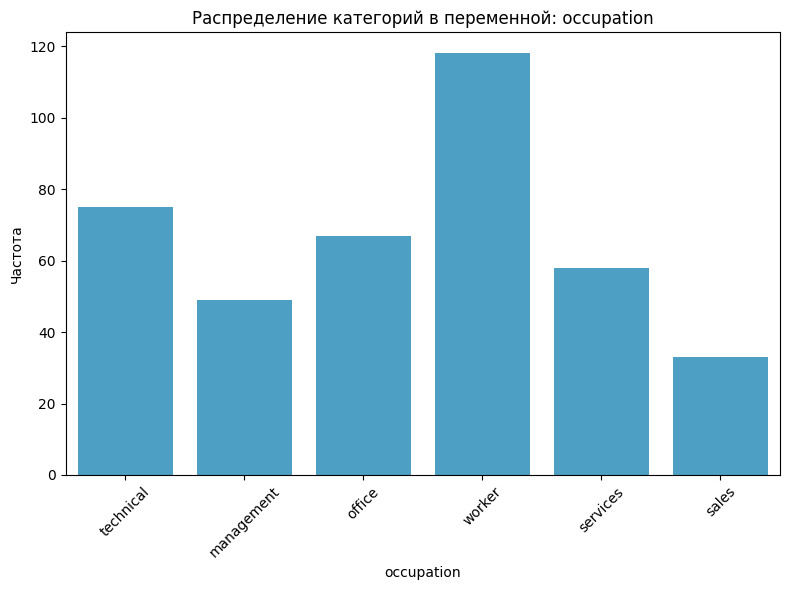

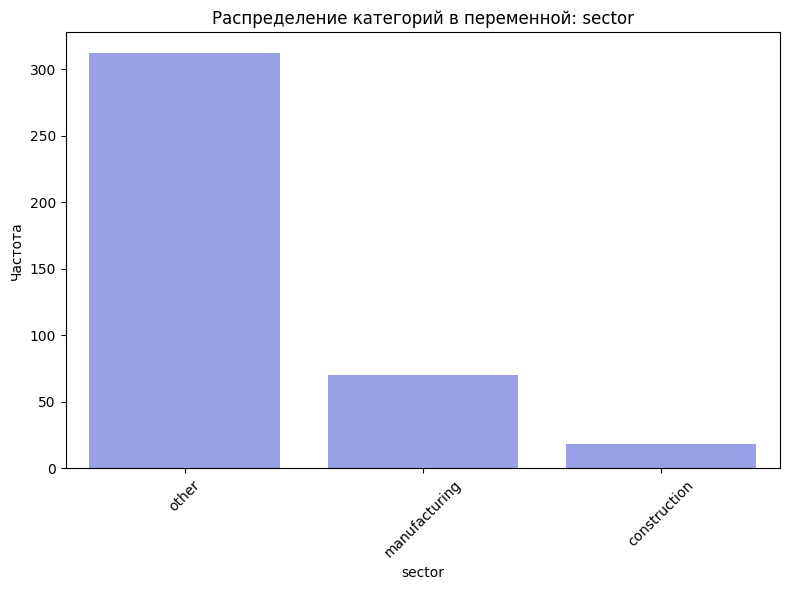

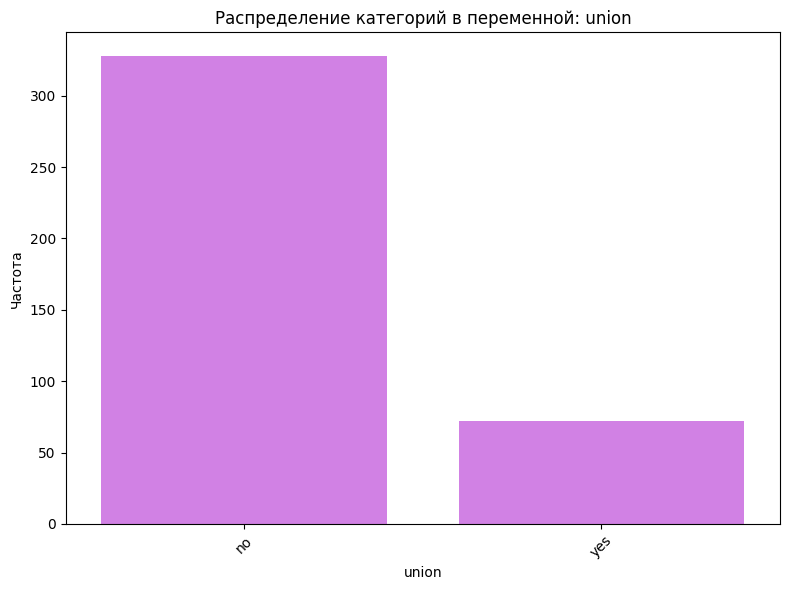

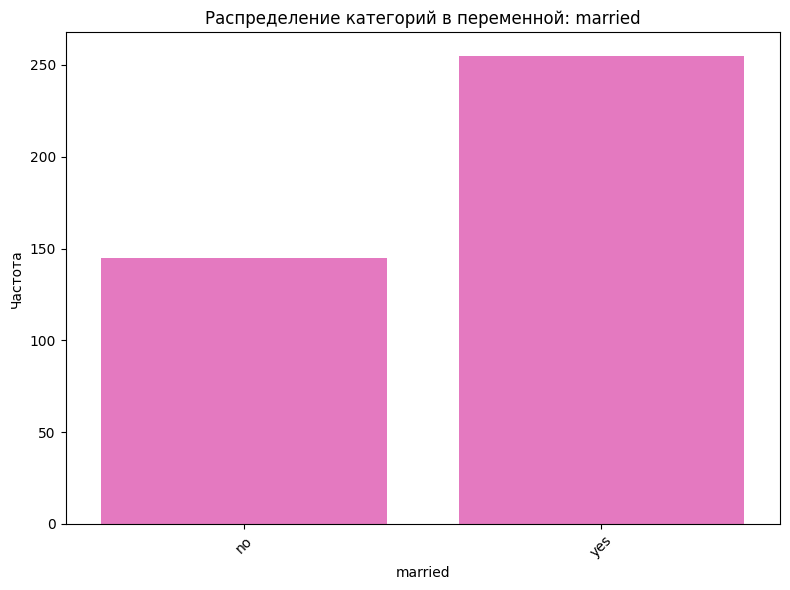

In [12]:
palette = sns.color_palette("husl", len(df.columns))
for i, column in enumerate(df.columns):
    plt.figure(figsize=(8, 6))
    
    # Проверяем тип данных столбца
    if df[column].dtype in ['int64', 'float64']:  # Числовые переменные
        sns.histplot(df[column], kde=True, color=palette[i], bins=30)
        plt.title(f'Распределение числовой переменной: {column}')
    elif df[column].dtype == 'object':  # Категориальные переменные
        sns.countplot(data=df, x=column, palette=[palette[i]])
        plt.title(f'Распределение категорий в переменной: {column}')
        plt.xticks(rotation=45)
    else:
        plt.title(f'Переменная {column} имеет неподдерживаемый тип: {df[column].dtype}')
    
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.tight_layout()
    plt.show()

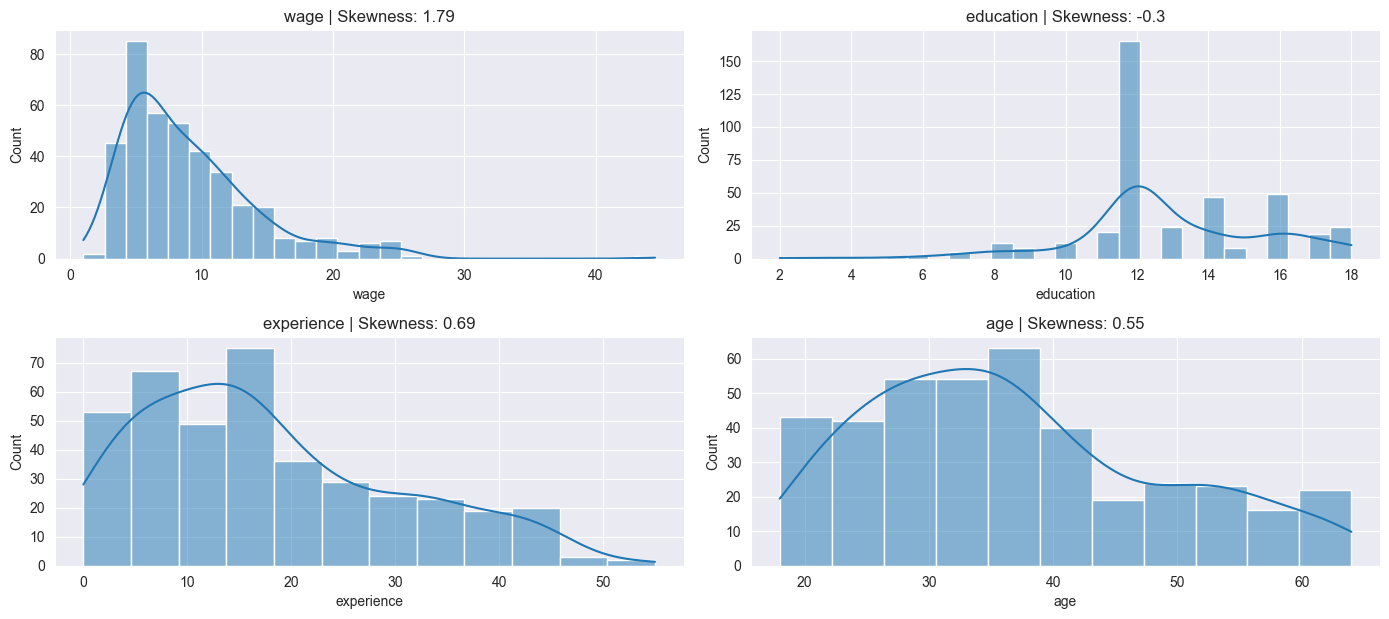

In [13]:
# Set Seaborn style
sns.set_style("darkgrid")

# Identify numerical columns
numerical_columns = df.select_dtypes(include=["int64", "float64"]).columns

# Plot distribution of each numerical feature
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")

# Adjust layout and show plots
plt.tight_layout()
plt.show()

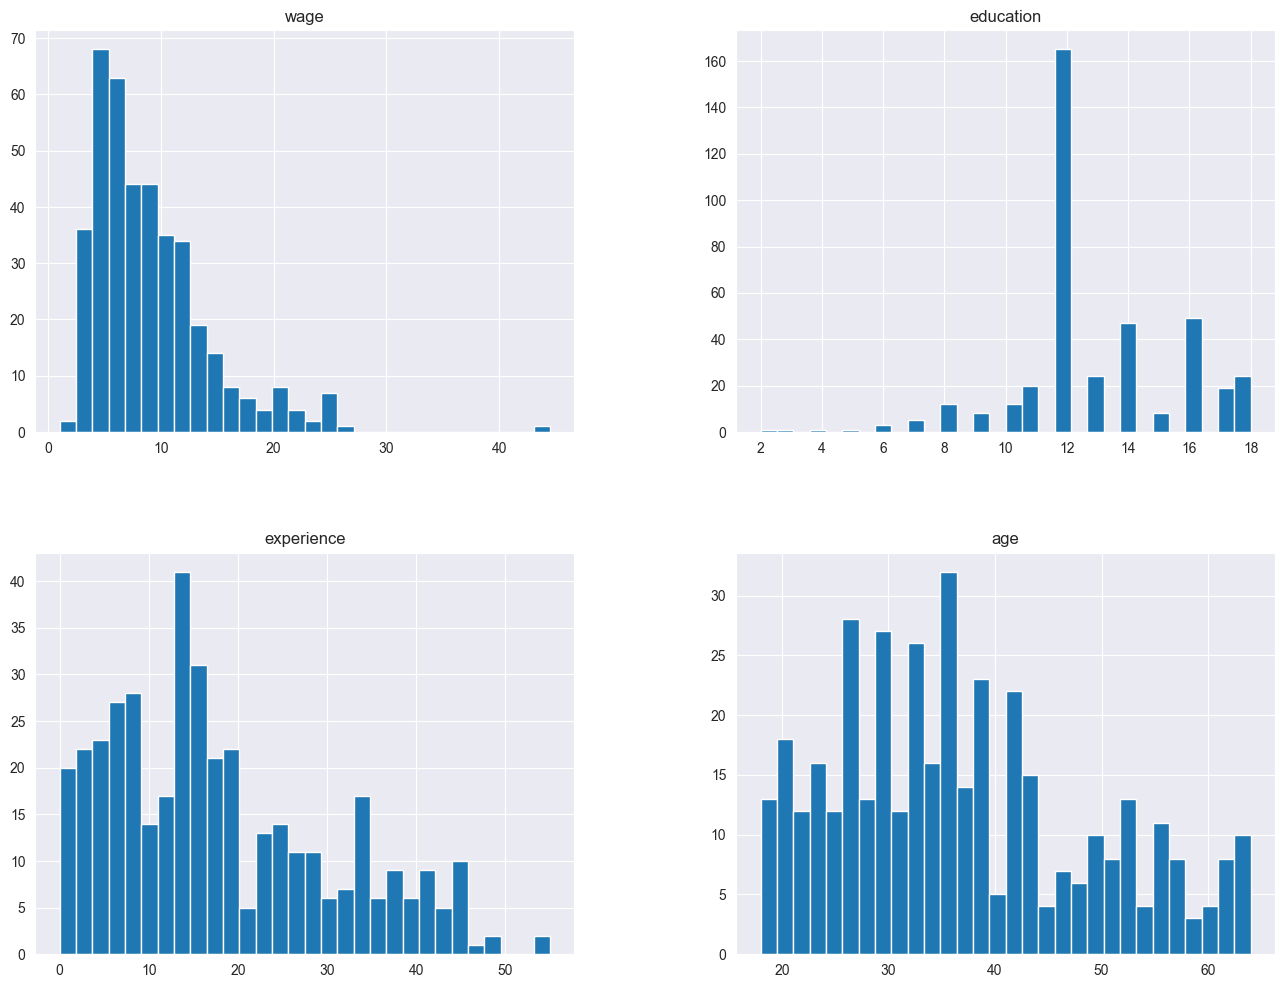

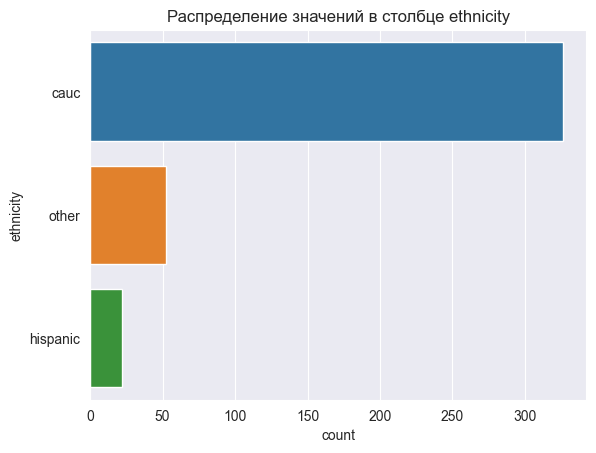

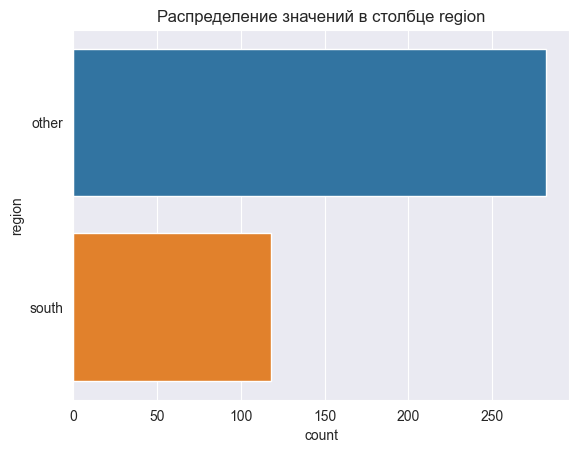

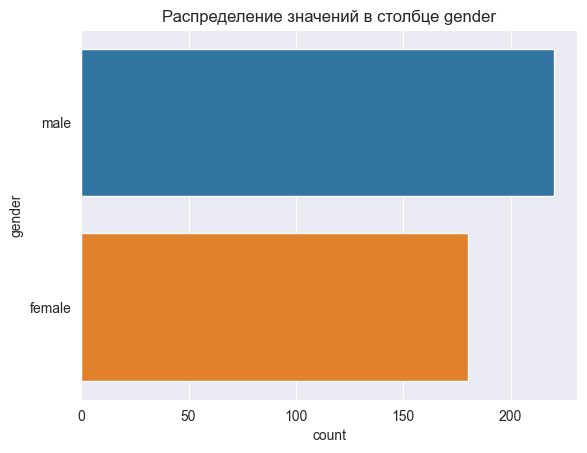

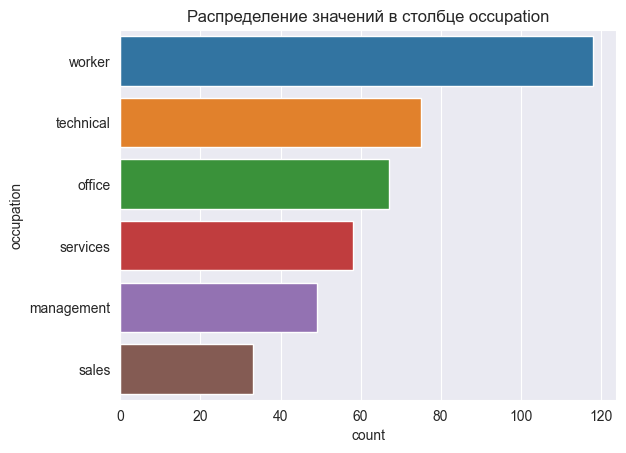

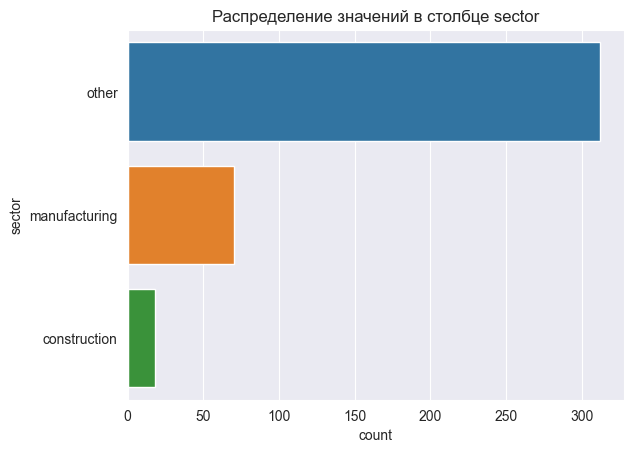

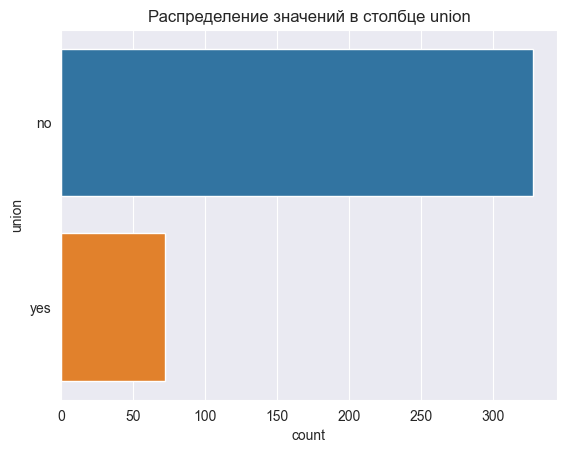

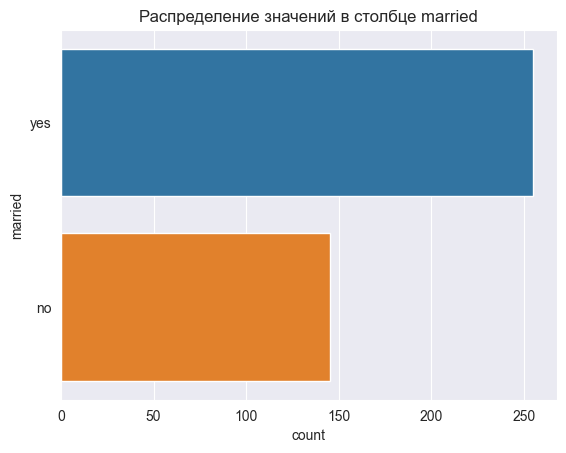

In [14]:
# Гистограммы для всех числовых столбцов
df.hist(figsize=(16, 12), bins=30)
plt.show()

# Анализ категориальных признаков
for col in df.select_dtypes(include=['object']).columns:
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Распределение значений в столбце {col}')
    plt.show()

# **Анализ выбросов**

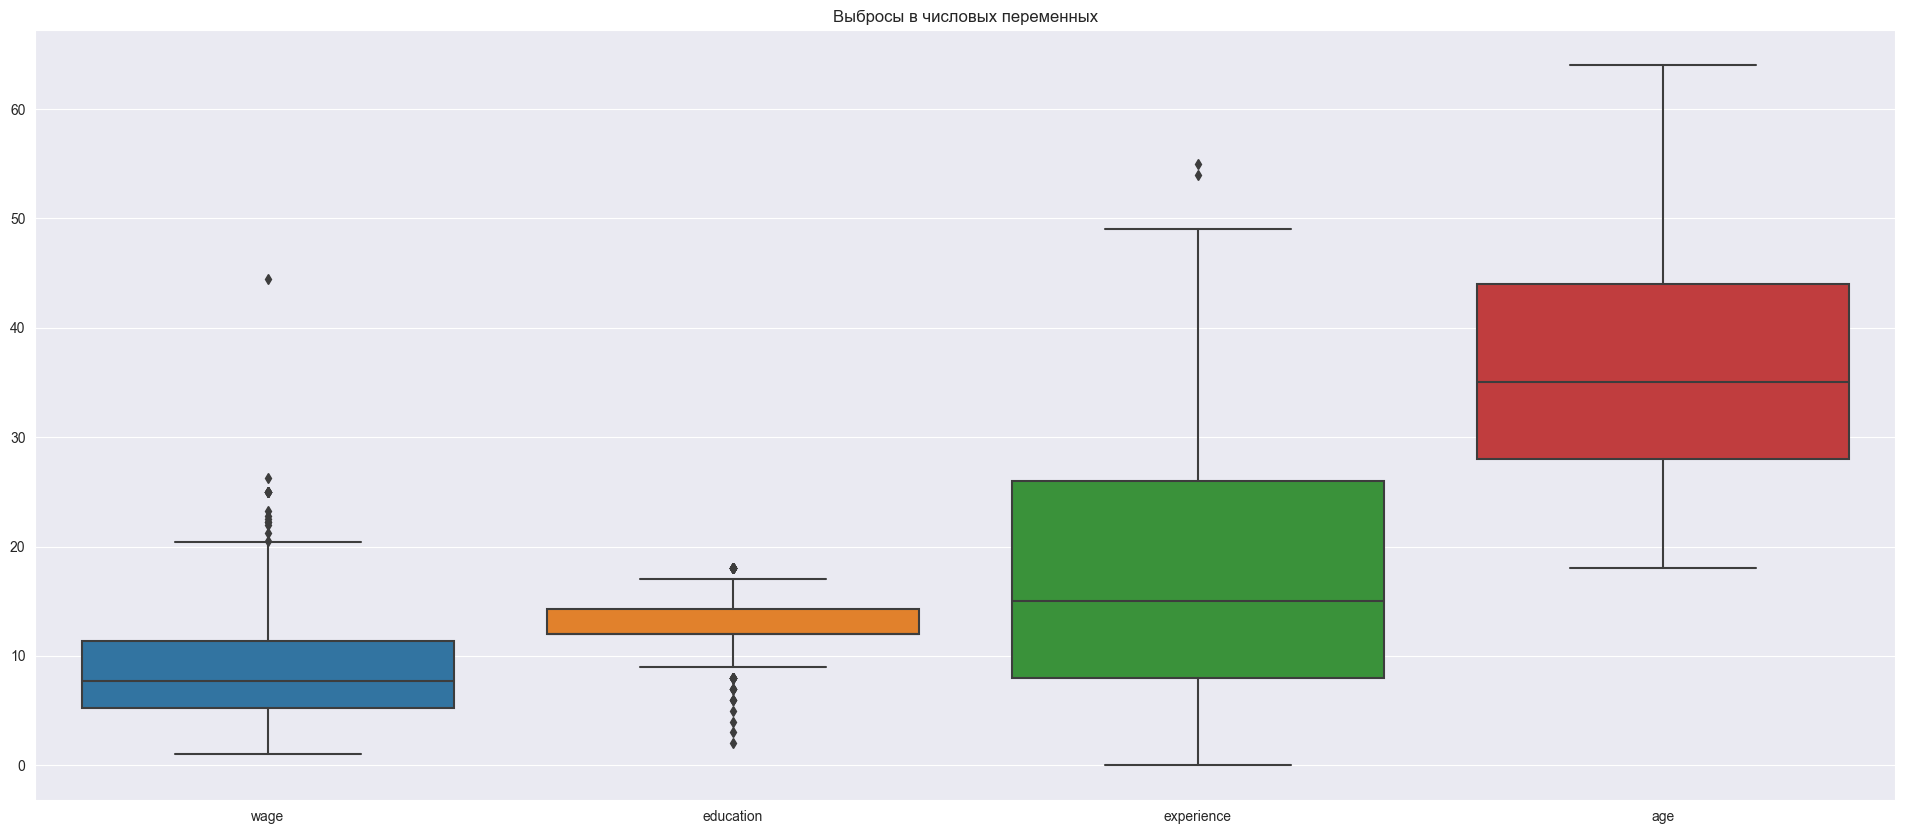

In [15]:
plt.figure(figsize=(24, 10))
sns.boxplot(data=df.select_dtypes(include=['float64', 'int64']))
plt.title("Выбросы в числовых переменных")
plt.show()

----------------------------------------
Столбец 'wage':
 - Q1: 5.24, Q3: 11.3275, IQR: 6.0875
 - Границы выбросов: ниже -3.891250000000001 или выше 20.458750000000002
 - Количество выбросов: 17


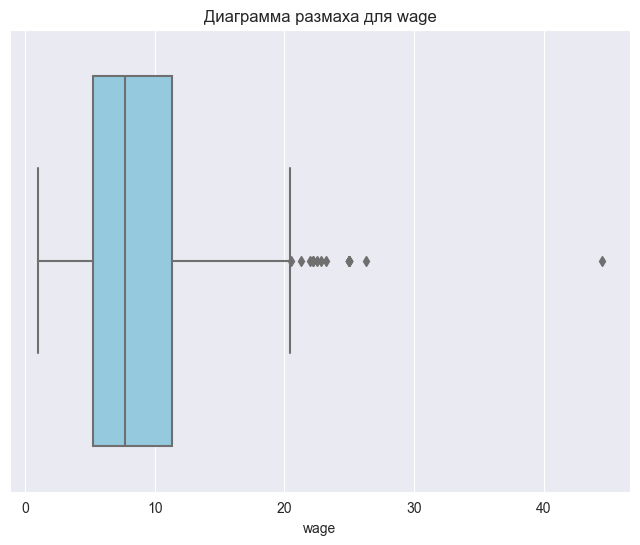

Примеры выбросов в столбце 'wage':
      wage
2    24.98
52   25.00
60   22.83
70   24.98
139  24.98
----------------------------------------
Столбец 'education':
 - Q1: 12.0, Q3: 14.25, IQR: 2.25
 - Границы выбросов: ниже 8.625 или выше 17.625
 - Количество выбросов: 48


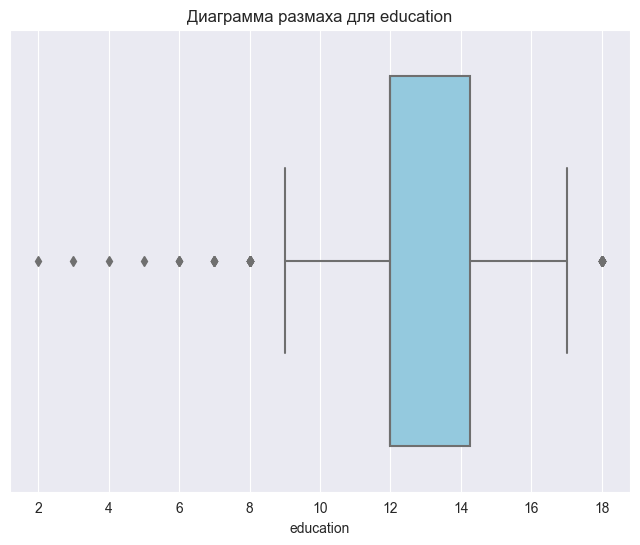

Примеры выбросов в столбце 'education':
    education
9           8
16          8
18          6
41         18
48         18
----------------------------------------
Столбец 'experience':
 - Q1: 8.0, Q3: 26.0, IQR: 18.0
 - Границы выбросов: ниже -19.0 или выше 53.0
 - Количество выбросов: 2


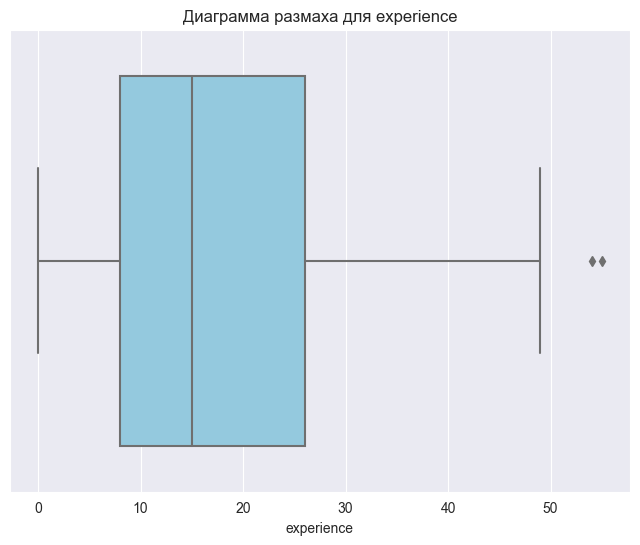

Примеры выбросов в столбце 'experience':
     experience
98           55
254          54
----------------------------------------
Столбец 'age':
 - Q1: 28.0, Q3: 44.0, IQR: 16.0
 - Границы выбросов: ниже 4.0 или выше 68.0
 - Количество выбросов: 0


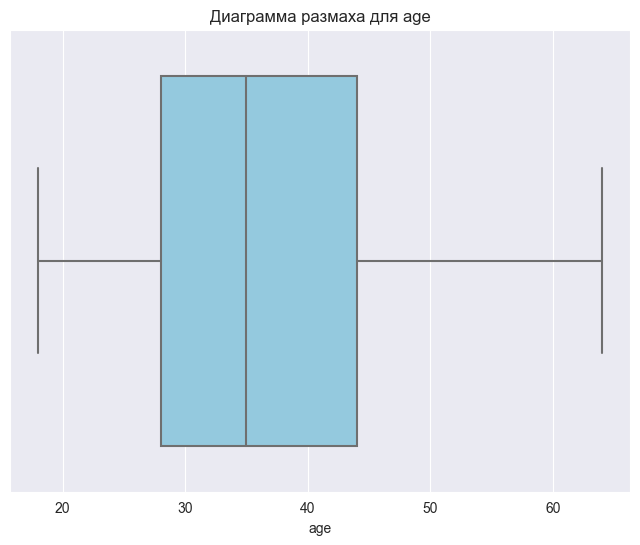

----------------------------------------
Общее количество выбросов во всех числовых столбцах: 67


In [16]:
def analyze_outliers(data, column):
    Q1 = data[column].quantile(0.25)  # Первый квартиль
    Q3 = data[column].quantile(0.75)  # Третий квартиль
    IQR = Q3 - Q1  # Межквартильный размах
    
    # Границы выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Определение выбросов
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    outlier_count = outliers.shape[0]
    
    print(f"Столбец '{column}':")
    print(f" - Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    print(f" - Границы выбросов: ниже {lower_bound} или выше {upper_bound}")
    print(f" - Количество выбросов: {outlier_count}")
    
    return outliers

# Анализ выбросов для числовых переменных
numeric_columns = df.select_dtypes(include=[np.number]).columns

for column in numeric_columns:
    print("-" * 40)
    outliers = analyze_outliers(df, column)

    # Визуализация выбросов
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[column], color='skyblue')
    plt.title(f'Диаграмма размаха для {column}')
    plt.show()

    if not outliers.empty:
        print(f"Примеры выбросов в столбце '{column}':")
        print(outliers[[column]].head())

# Дополнительно: Подсчет общего числа выбросов в наборе данных
total_outliers = 0
for column in numeric_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    total_outliers += ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()

print("-" * 40)
print(f"Общее количество выбросов во всех числовых столбцах: {total_outliers}")

# **Корреляционный анализ**

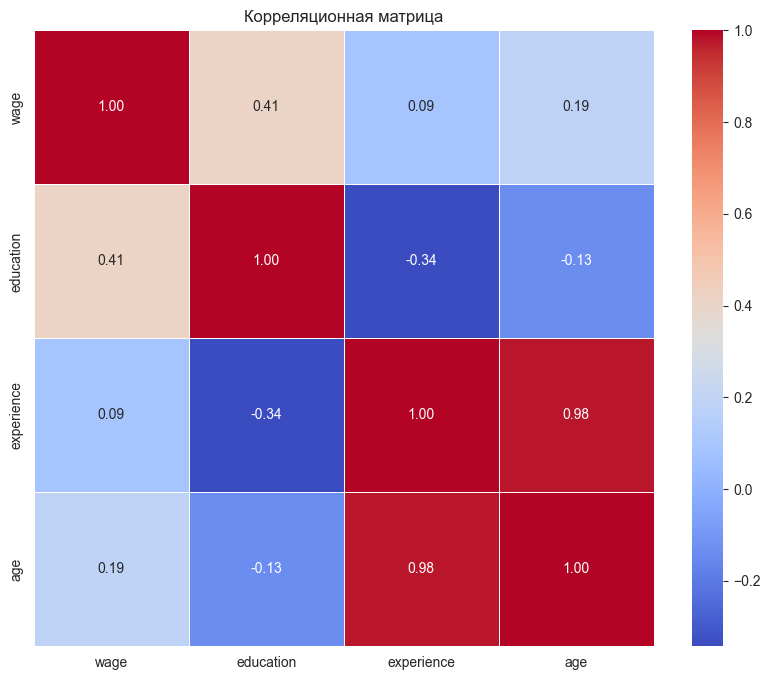

In [17]:
numeric_columns = df.select_dtypes(include=['number'])

# Построение корреляционной матрицы
correlation_matrix = numeric_columns.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

# **pairplot**

In [18]:
# # Set the color palette
# sns.set_palette("Pastel1")

# # Assuming 'df' is your DataFrame
# plt.figure(figsize=(10, 6))

# # Using Seaborn to create a pair plot with the specified color palette
# sns.pairplot(df)

# plt.suptitle('Pair Plot for DataFrame')
# plt.show()

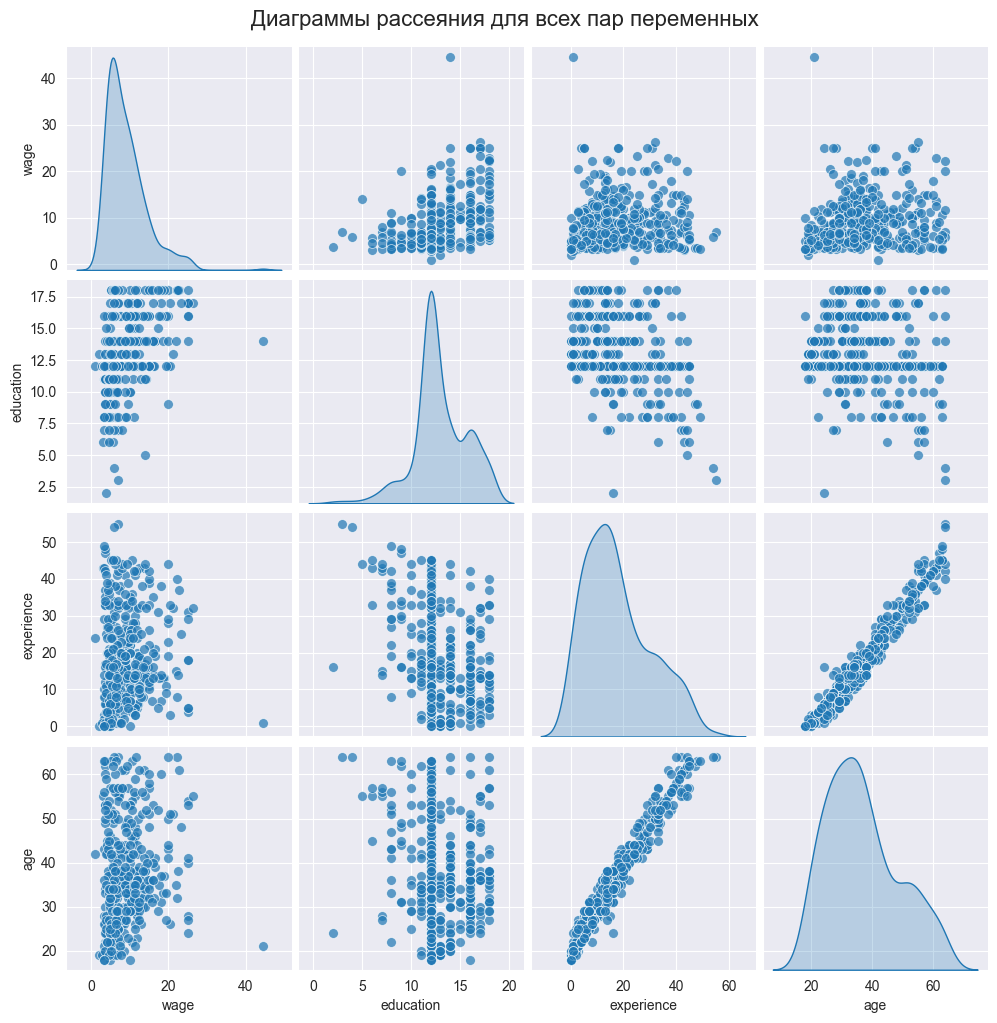

In [19]:
numeric_columns = df.select_dtypes(include=['number'])

# Построение Pairplot
sns.pairplot(numeric_columns, diag_kind='kde', kind='scatter', plot_kws={'alpha': 0.7, 's': 50})
plt.suptitle('Диаграммы рассеяния для всех пар переменных', y=1.02, fontsize=16)
plt.show()

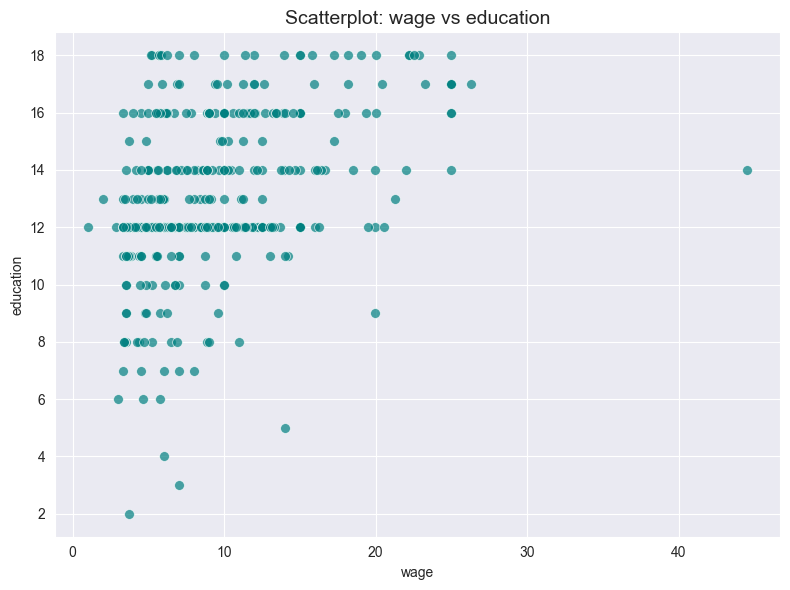

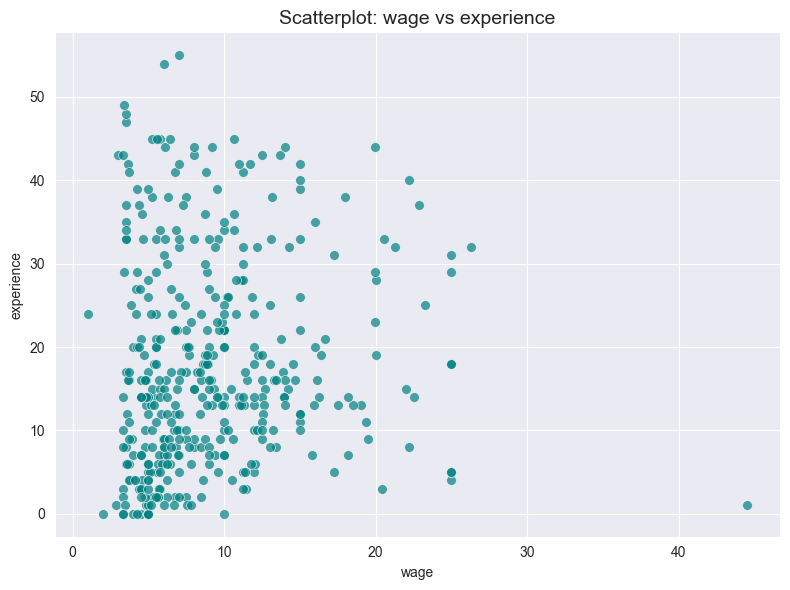

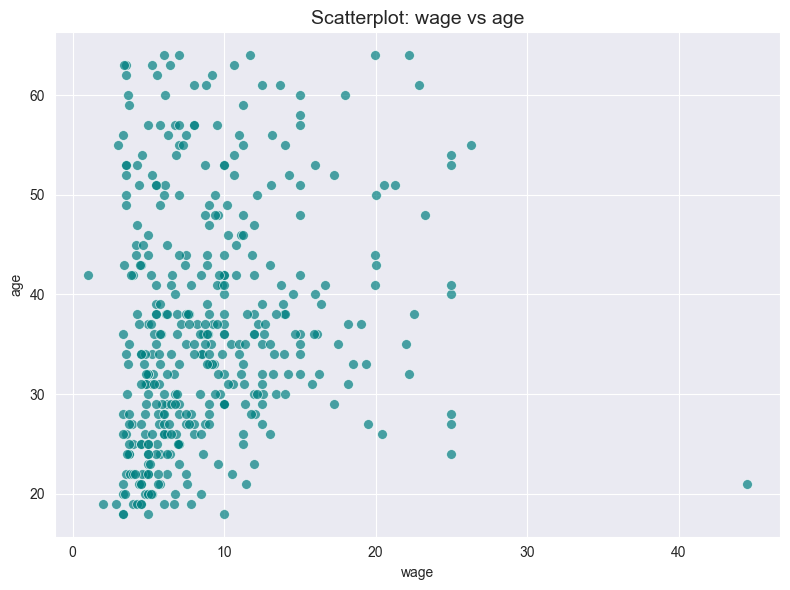

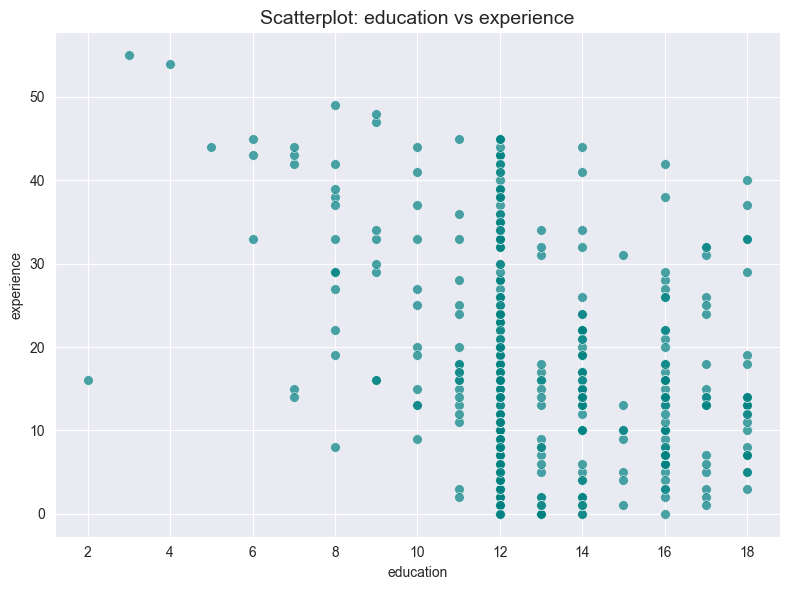

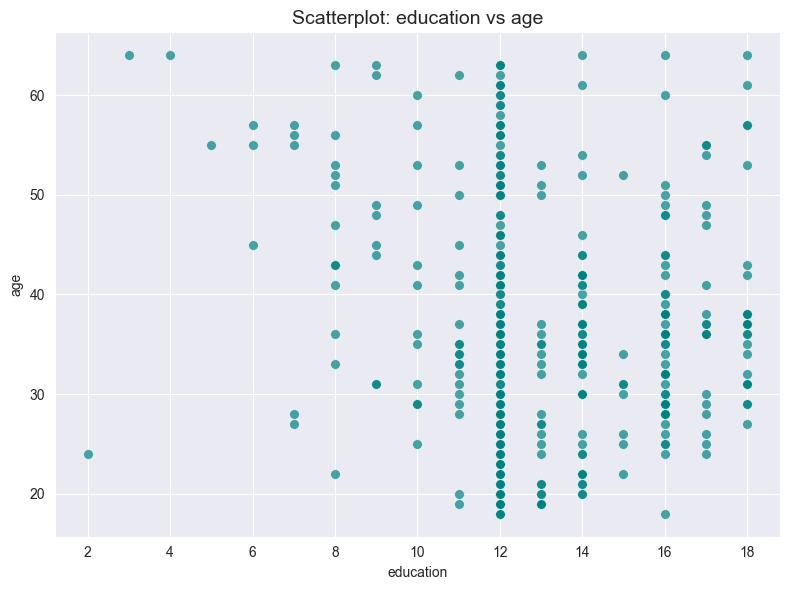

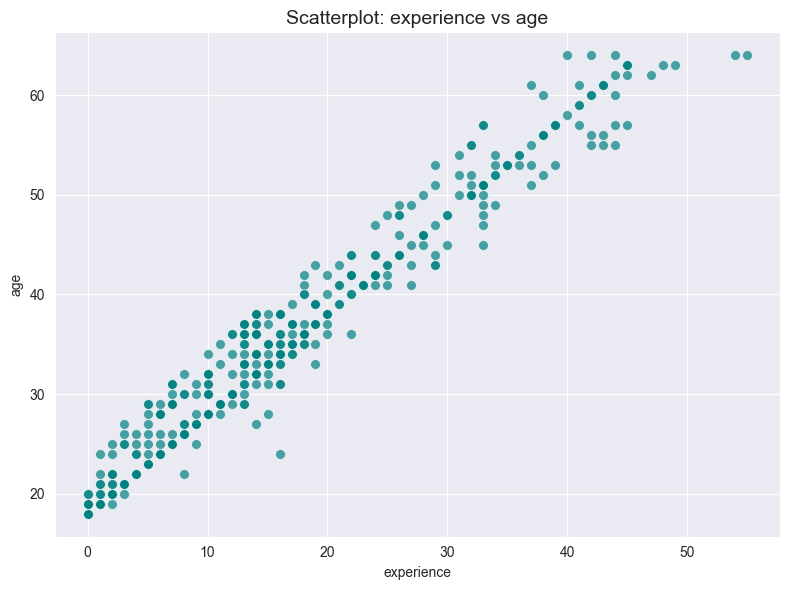

In [20]:
import itertools
import numpy as np

# Получение всех пар числовых столбцов
columns = numeric_columns.columns
pairs = list(itertools.combinations(columns, 2))

# Построение графиков
for x, y in pairs:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=x, y=y, alpha=0.7, color='teal', s=50)
    plt.title(f'Scatterplot: {x} vs {y}', fontsize=14)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# **Анализ категориальных переменных**

=== Анализ столбца 'ethnicity' ===
Уникальные значения: 3
Наиболее частые категории:
ethnicity
cauc        326
other        52
hispanic     22
Name: count, dtype: int64


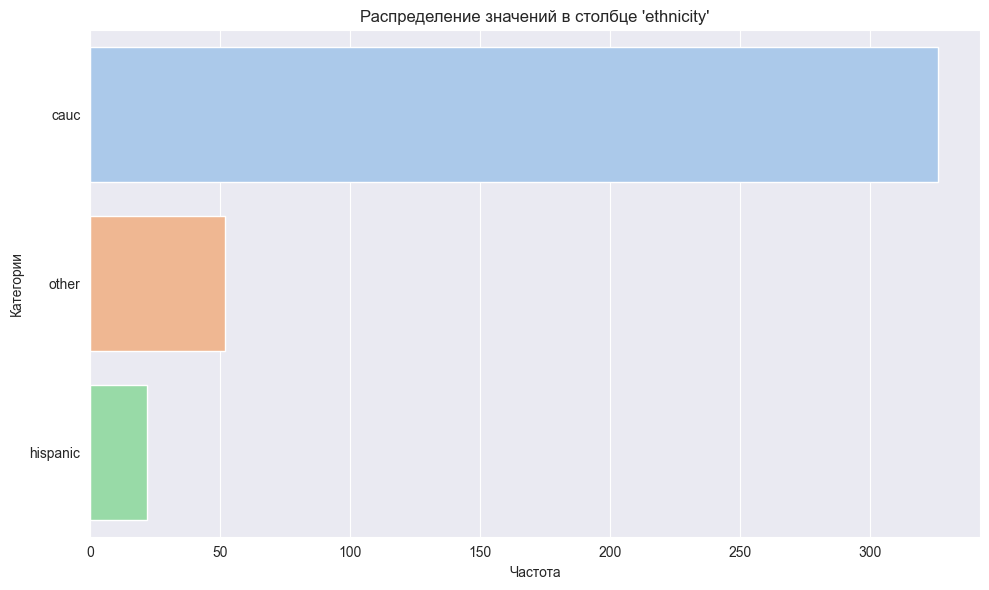

=== Анализ столбца 'region' ===
Уникальные значения: 2
Наиболее частые категории:
region
other    282
south    118
Name: count, dtype: int64


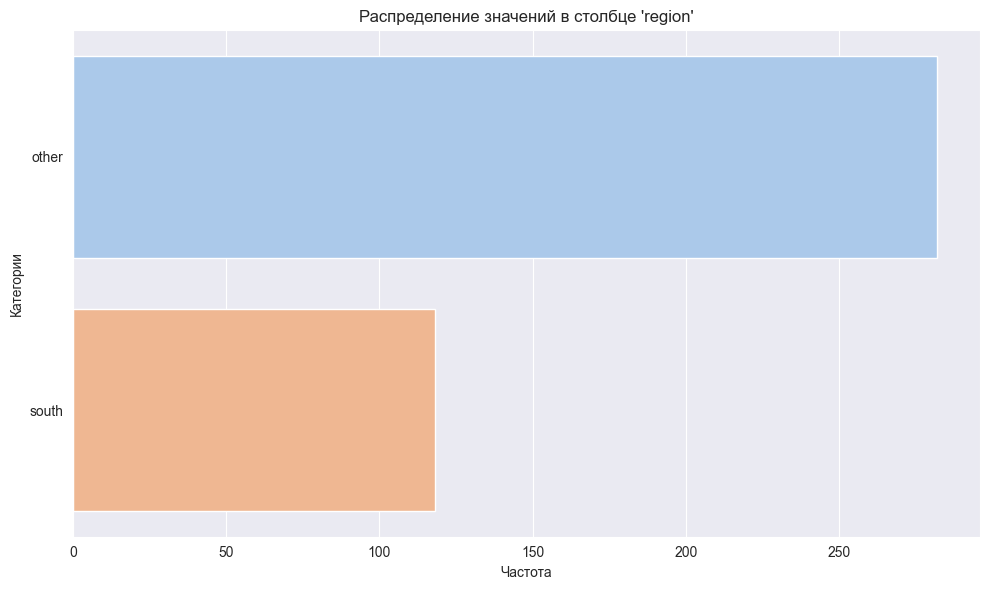

=== Анализ столбца 'gender' ===
Уникальные значения: 2
Наиболее частые категории:
gender
male      220
female    180
Name: count, dtype: int64


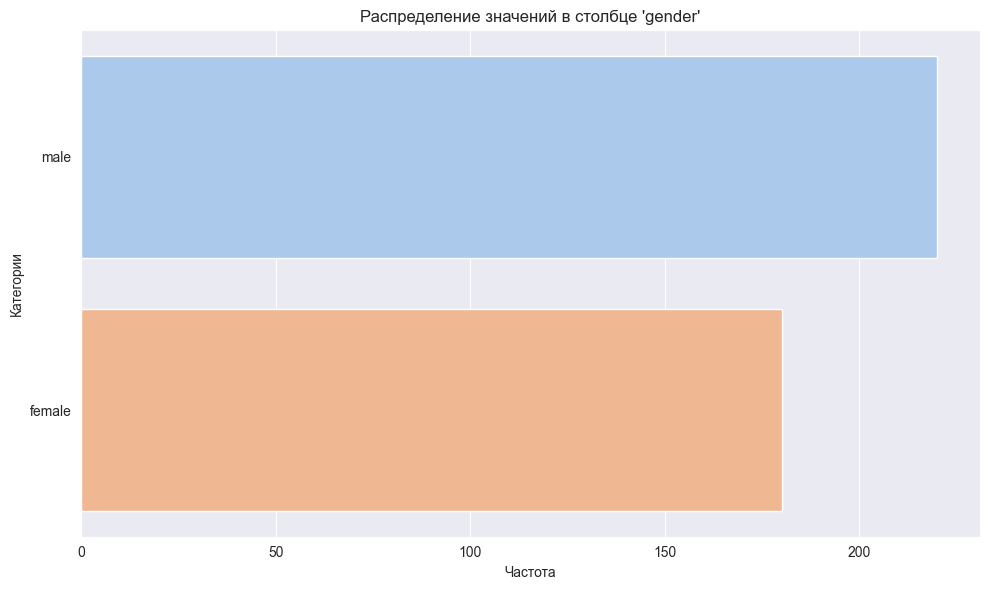

=== Анализ столбца 'occupation' ===
Уникальные значения: 6
Наиболее частые категории:
occupation
worker        118
technical      75
office         67
services       58
management     49
Name: count, dtype: int64


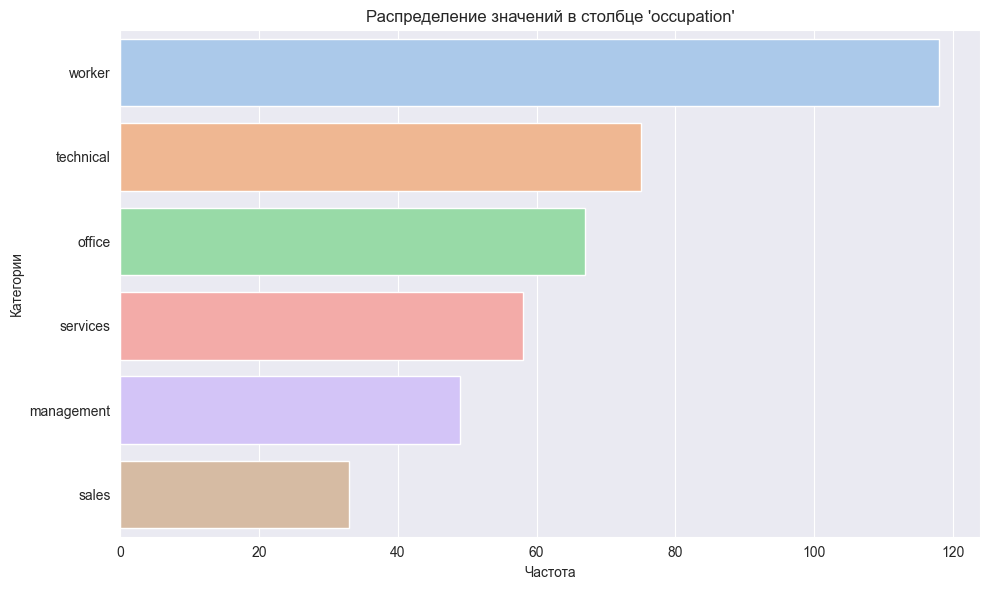

=== Анализ столбца 'sector' ===
Уникальные значения: 3
Наиболее частые категории:
sector
other            312
manufacturing     70
construction      18
Name: count, dtype: int64


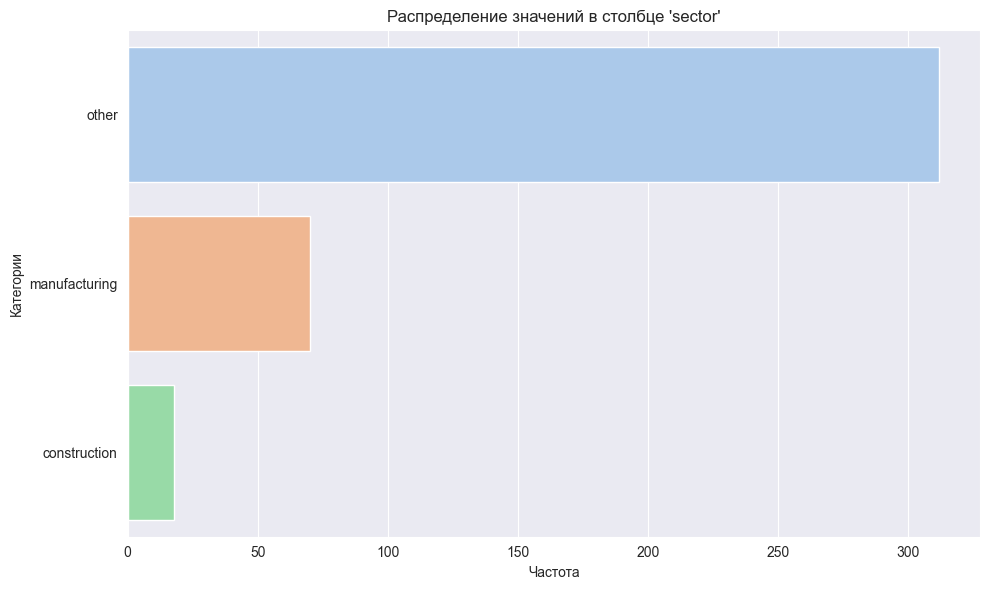

=== Анализ столбца 'union' ===
Уникальные значения: 2
Наиболее частые категории:
union
no     328
yes     72
Name: count, dtype: int64


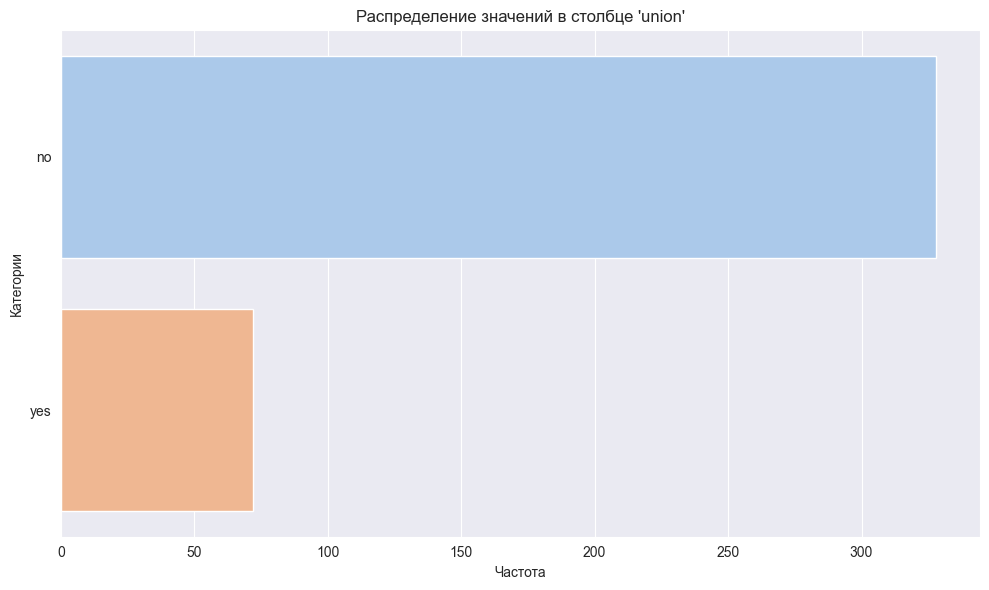

=== Анализ столбца 'married' ===
Уникальные значения: 2
Наиболее частые категории:
married
yes    255
no     145
Name: count, dtype: int64


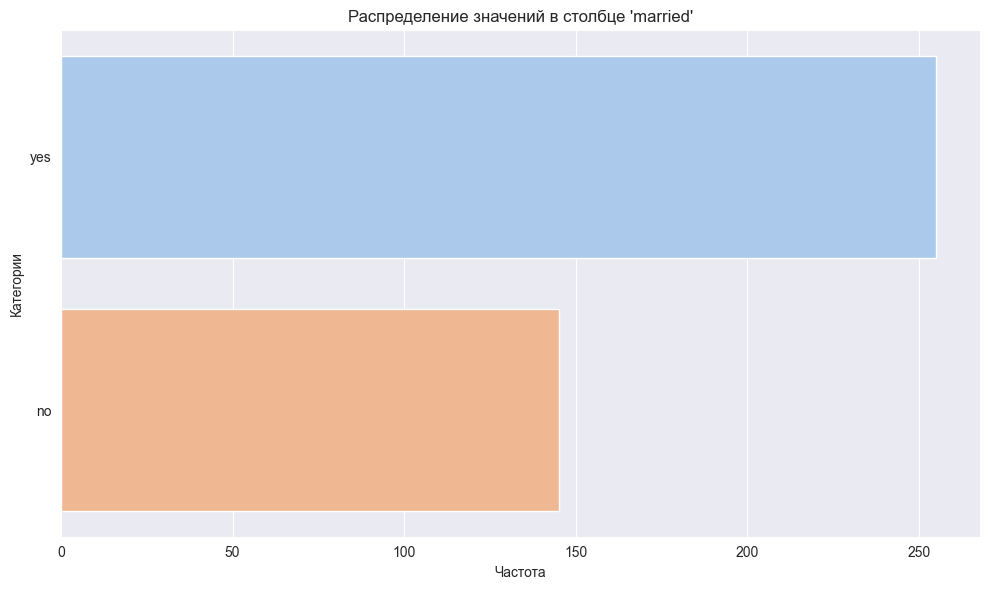

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_categorical_columns(df):
    """
    Выполняет анализ категориальных переменных в наборе данных.
    
    :param df: DataFrame с данными.
    """
    # Выбор категориальных переменных
    cat_columns = df.select_dtypes(include=['object', 'category']).columns
    if not cat_columns.any():
        print("Категориальных переменных не найдено!")
        return
    
    for col in cat_columns:
        print(f"=== Анализ столбца '{col}' ===")
        print(f"Уникальные значения: {df[col].nunique()}")
        print(f"Наиболее частые категории:\n{df[col].value_counts().head()}")
        
        # Построение графиков распределения
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette="pastel")
        plt.title(f"Распределение значений в столбце '{col}'")
        plt.xlabel("Частота")
        plt.ylabel("Категории")
        plt.tight_layout()
        plt.show()

def visualize_relationship_cat_num(df, cat_column, num_column):
    """
    Визуализирует связь между категориальной и числовой переменными.
    
    :param df: DataFrame с данными.
    :param cat_column: Название категориального столбца.
    :param num_column: Название числового столбца.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=cat_column, y=num_column, palette="Set3")
    plt.title(f"Связь между '{cat_column}' и '{num_column}'")
    plt.xlabel(cat_column)
    plt.ylabel(num_column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

analyze_categorical_columns(df)
    
# Визуализация связи категориальной и числовой переменной
# visualize_relationship_cat_num(df, cat_column='Category', num_column='Value')

# **ДОП ГРАФИКИ**

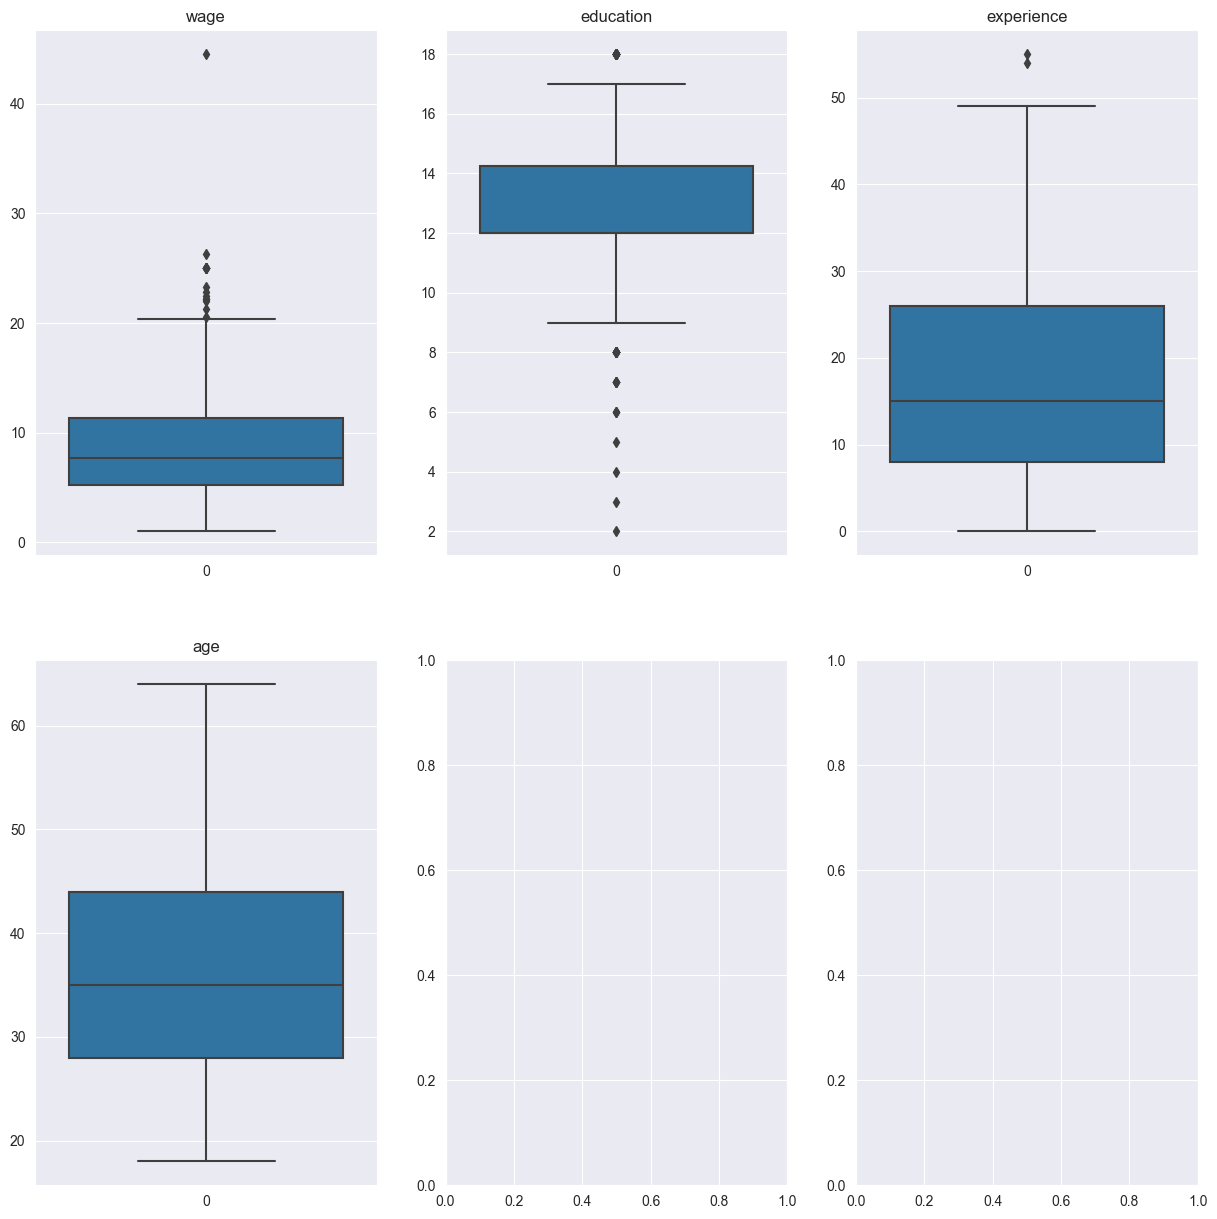

In [22]:
col_nums = 3  # how many plots per row
row_nums = math.ceil(len(df.select_dtypes(include=[np.number]).columns) / col_nums)  # how many rows of plots
# print(col_nums, row_nums)
_, axes = plt.subplots(nrows=row_nums, ncols=col_nums, figsize=(15,15))
for i, col in enumerate(df.select_dtypes(include=[np.number]).columns):
    sns.boxplot(data=df[col], ax=axes.flatten()[i]).set_title(col)
plt.show()

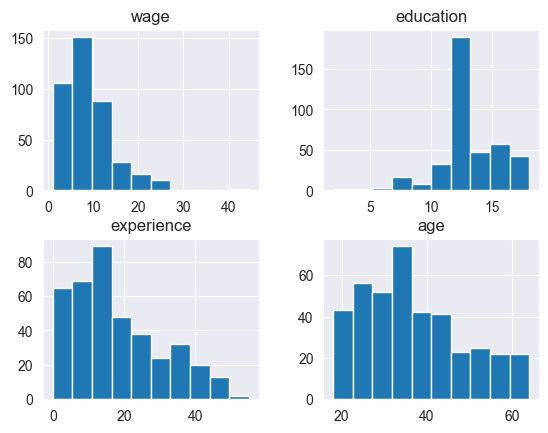

In [23]:
df.hist();

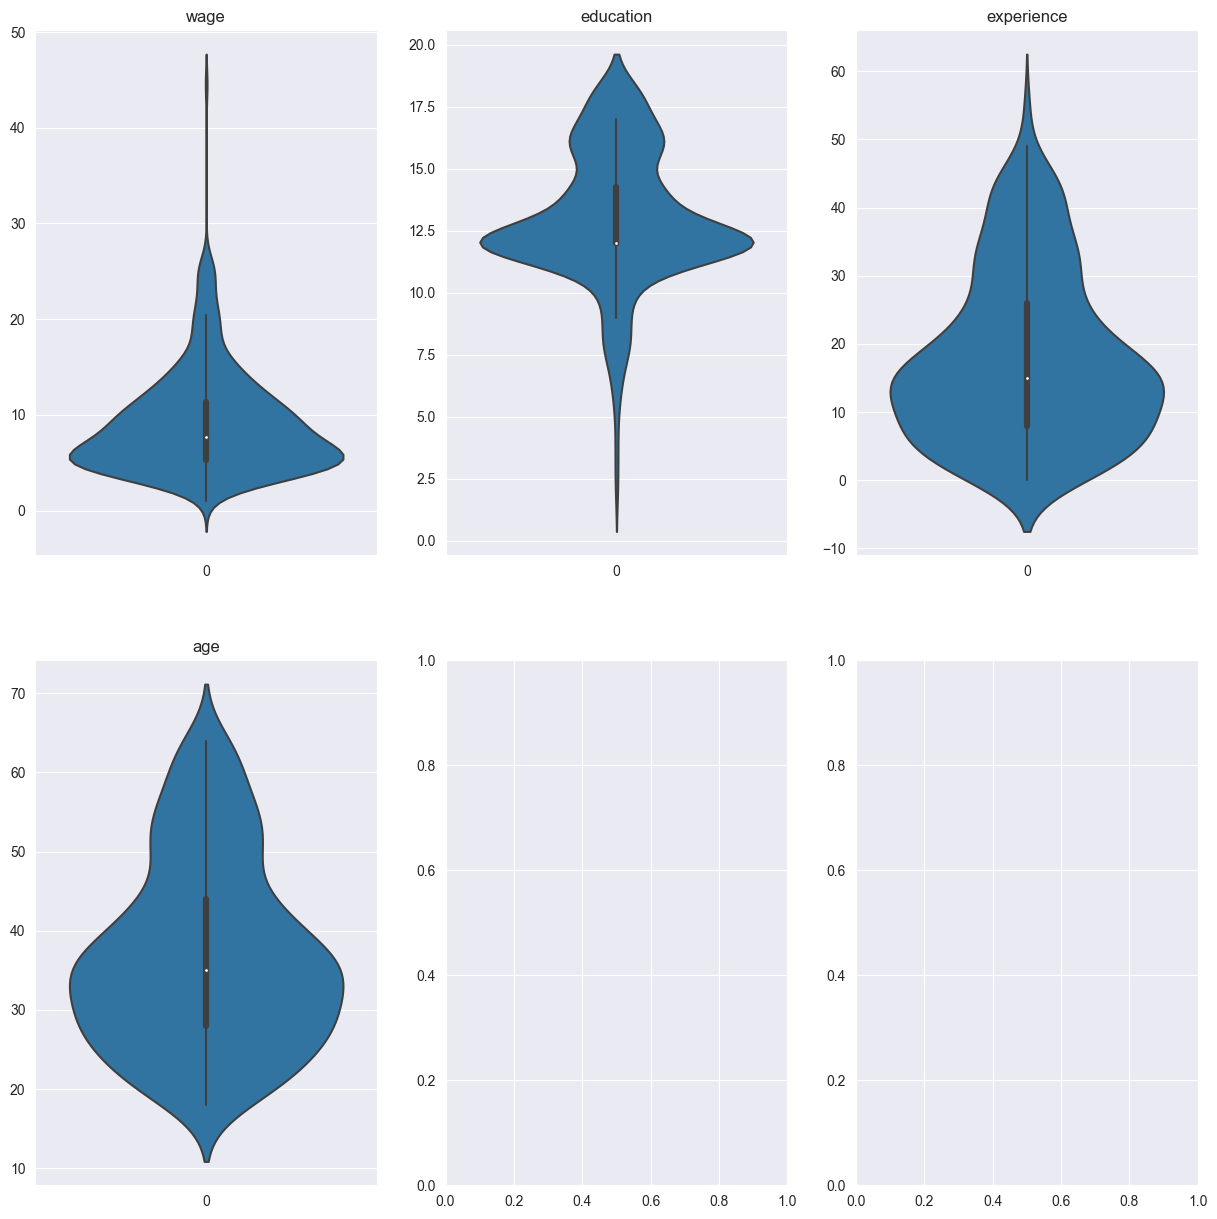

In [24]:
col_nums = 3  # how many plots per row
row_nums = math.ceil(len(df.select_dtypes(include=[np.number]).columns) / col_nums)  # how many rows of plots
# print(col_nums, row_nums)
_, axes = plt.subplots(nrows=row_nums, ncols=col_nums, figsize=(15,15))
for i, col in enumerate(df.select_dtypes(include=[np.number]).columns):
    sns.violinplot(data=df[col], ax=axes.flatten()[i]).set_title(col)
plt.show()